# 📌 Prototype Classifier Testing — Continuation of MainNotebook.ipynb (Read MainNotebook first).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import sys
import os
import pyarrow.parquet as pq

project_dir = os.path.abspath("/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project")
sys.path.append(project_dir)

from src.processing import extract_date_components

In [2]:
# =======================
# 📅 Study Period – Starting from the First Day of the Month
# =======================

dataset_datetime_series = pd.Series(['2024-01-01'])

# =======================
# 🚢 Boat Parameters
# =======================
SOG_MIN, SOG_MAX = 8.0, 30.0 #Knots
VALID_TYPES = [70, 71, 72, 80, 60]

In [3]:
YEAR, MONTH_NUM, MONTH_ABBR = extract_date_components(dataset_datetime_series)

print(f"Year: {YEAR}, Month Number: {MONTH_NUM}, Month Abbreviation: {MONTH_ABBR}")

KAGGLE_DATASET = f"bwandowando/{YEAR}-us-coast-guard-noaa-ais-dataset"
SRC_AIS_FILE = f"{YEAR}_NOAA_AIS_logs_{MONTH_NUM}.parquet"     # ex: 2024_NOAA_AIS_logs_01.parquet
SRC_SHIP_FILE = f"{YEAR}_NOAA_AIS_ships_{MONTH_NUM}.parquet"    # ex: 2024_NOAA_AIS_ships_01.parquet
DST_DIR = f"/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/AIS{YEAR}"
DST_AIS_FILE = f"NOAA_AIS_{MONTH_ABBR}_{YEAR}.parquet"         # ex: NOAA_AIS_JAN_2024.parquet
DST_SHIP_FILE = f"NOAA_SHIPS_{MONTH_ABBR}_{YEAR}.parquet"
MERCATOR_FILE = f"/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/Mercator/mercator_{MONTH_ABBR}_{YEAR}.nc"

print("=" * 50)
print(f"📅  Year: {YEAR} | Month: {MONTH_NUM} ({MONTH_ABBR})")
print("-" * 50)
print(f"📦 Kaggle Dataset : {KAGGLE_DATASET}")
print(f"📄 Source Logs    : {SRC_AIS_FILE}")
print(f"📄  Source Ships  : {SRC_SHIP_FILE}")
print(f"📁 Output Logs    : {DST_AIS_FILE}")
print(f"📁 Output Ships   : {DST_SHIP_FILE}")
print(f"🌊 Mercator  : {MERCATOR_FILE}")
print("=" * 50)

Year: 2024, Month Number: 01, Month Abbreviation: JAN
📅  Year: 2024 | Month: 01 (JAN)
--------------------------------------------------
📦 Kaggle Dataset : bwandowando/2024-us-coast-guard-noaa-ais-dataset
📄 Source Logs    : 2024_NOAA_AIS_logs_01.parquet
📄  Source Ships  : 2024_NOAA_AIS_ships_01.parquet
📁 Output Logs    : NOAA_AIS_JAN_2024.parquet
📁 Output Ships   : NOAA_SHIPS_JAN_2024.parquet
🌊 Mercator  : /content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/Mercator/mercator_JAN_2024.nc


# 3./ Machine Learning implementation

In [4]:
# Dependencies

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
import os
from tqdm import trange
import torch.optim as optim


sys.path.append(os.path.abspath("/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project"))
dataset_path = os.path.join(DST_DIR, f"DATASET_{MONTH_ABBR}_{YEAR}.parquet")

from models.ml_utils import generate_dataloader, corr_loss
from models.SILoss import si_loss
from models.MLP import MLP_STW_network
from models.FeatureSelfAttention import FeatureSelfAttention_network

path = "/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/MLP_classifier_410E_lr-3.pth"

c_max = 5
length_max = 400
width_max = 60
draft_max = 25

batch_size = 64

In [5]:
# ============================================
# Create TrainDataLoader / EvalDataset - AIS Deep Learning Project
# ============================================

train_loader, eval_dataset = generate_dataloader(dataset_path=dataset_path,
                        sog_max=SOG_MAX,
                        sog_min=SOG_MIN,
                        c_max=c_max,
                        length_max=length_max,
                        width_max=width_max,
                        draft_max=draft_max,
                        batch_size=batch_size,
                        unique_MMSI=False,
                        normalize=True,
                        classifier=True
                        )

Velocity Threshold = 0.75
Percentage of sea surface velocity > 0.75 m.s-1: 13.677077293395996
Heading Tensor Shape:  torch.Size([121583])
COG Tensor Shape:  torch.Size([121583])
SOG Tensor Shape:  torch.Size([121583])
U Tensor Shape:  torch.Size([121583])
V Tensor Shape:  torch.Size([121583])
Dataset lenght:  121583
Train Subset lenght:  91187


# Classifier

### Justification for batch size = 64

We choose **batch size = 64** based on two simple rules for imbalanced datasets, where the positive rate is  
$p = 0.13$.

---

**1) Ensure enough positives per batch**

The expected number of positives in a batch is  
$E = p \cdot B$.

We aim for $E \in [8, 16]$ to ensure sufficient positive samples per gradient update.  

- For $E = 8$: $B \approx \tfrac{8}{0.13} \approx 62$.  
- For $E = 16$: $B \approx \tfrac{16}{0.13} \approx 123$.  

Thus, with $B = 64$, we obtain  
$E = 0.13 \times 64 \approx 8.3$ positives per batch, which is within the target range.

---

**2) Avoid all-negative batches**

The probability that a batch contains no positives is  
$P(\overline{positives}) = (1 - p)^B$.

- To keep $P(0) \leq 0.1\%$, we require $B \geq \tfrac{\ln(0.001)}{\ln(1 - p)} \approx 50$.  

With $B = 64$,  
$P(0) = (1 - 0.13)^{64} \approx 0.00013$


In [6]:
import torch.nn as nn
import torch.nn.functional as F
#! pip install captum
#from captum.attr import LRP

def f1_binary(
    preds: torch.Tensor,
    target: torch.Tensor,
    threshold: float = 0.5,
    from_logits: bool = True,
    epsilon: float = 1e-8,
):
    """
    Calcule le F1-score binaire entre preds et target.

    Args:
        preds: Tensor des prédictions du modèle.
               - Si from_logits=True : logits bruts (avant sigmoid), de forme (...,)
               - Si from_logits=False : probabilités dans [0,1], de forme (...,)
        target: Tensor des labels binaires {0,1}, même forme que preds.
        threshold: Seuil pour binariser les prédictions.
        from_logits: Si True, applique torch.sigmoid avant seuillage.
        epsilon: Petite constante pour éviter la division par zéro.

    Returns:
        f1: scalaire (tensor 0-dim) du F1-score.
        precision: précision binaire.
        recall: rappel binaire.
    """
    if from_logits:
        probs = torch.sigmoid(preds)
    else:
        probs = preds

    y_pred = (probs >= threshold).float()
    y_true = target

    tp = torch.sum(y_pred * y_true)
    fp = torch.sum(y_pred * (1 - y_true))
    fn = torch.sum((1 - y_pred) * y_true)

    print(tp, fp, fn)

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1, precision, recall

class BinaryFocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # pondération optionnelle entre classes
        self.reduction = reduction

    def forward(self, logits, targets):
        # Sigmoid → probas
        p = torch.sigmoid(logits)
        # p_t = p si y=1, sinon 1-p
        p_t = p * targets + (1 - p) * (1 - targets)
        # facteur focal
        focal_factor = (1 - p_t).pow(self.gamma)
        # log probas avec stabilité num.
        loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        loss = focal_factor * loss

        # pondération alpha (optionnelle)
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss



Device : cpu
MLP_STW_network(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


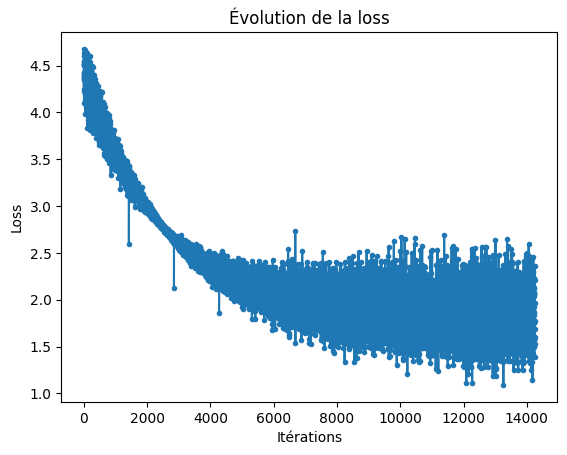

In [8]:
from tqdm import trange
import torch.optim as optim

# -- HyperParameters --
nb_epoch = 10
learning_rate = 1e-5
train_path = "/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/.pth"
wd = 1e-4
pos_weight = torch.tensor(1.0) #torch.tensor(neg / pos).clamp(1., 100.)  # limit for stability
# Détection du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
# **0** Nouvelle Loss
criterion = BinaryFocalLoss(gamma=3.0, alpha=0.5)

# Instanciation du modèle
model = MLP_STW_network(c_max=c_max,
                        sog_min=SOG_MIN, sog_max=SOG_MAX,
                        out_dim=1).to(device)
"""
# **1** Initialiser le biais du dernier layer
p = (pos / (pos + neg)).clamp(1e-4, 1 - 1e-4)  # prior positif (torch.Tensor)

last = None
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        last = m  # suppose que le dernier Linear est la tête

# logit(p) = ln(p / (1 - p))
with torch.no_grad():
    last.bias.fill_(np.log(float(p / (1 - p))))

# **2** Desacive le weight decay sur la derniere couche
decay, nodecay = [], []
for n,p in model.named_parameters():
    (nodecay if p.ndim==1 else decay).append(p)  # biais & gammas/betas sans decay
opt = torch.optim.AdamW(
    [{"params": decay, "weight_decay": 1e-4},
     {"params": nodecay, "weight_decay": 0.0}],
    lr=1e-4, betas=(0.7, 0.95), eps=1e-5
)

"""
print(model)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), amsgrad=True, eps=1e-6)

train_losses = []

for epoch in trange(nb_epoch):
    for i, (heading, cog, sog, length, width, draft, _, _, class_velo) in enumerate(train_loader):
        heading = heading.to(device)
        cog = cog.to(device)
        sog = sog.to(device)
        length = length.to(device)
        width = width.to(device)
        draft = draft.to(device)
        class_velo = class_velo.to(device)

        # Forward pass
        logits = model(heading, cog, sog).squeeze(-1)
        loss = criterion(logits, class_velo)

        bs = logits.shape[0]
        train_losses.append(loss.item() * bs)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()


plt.plot(train_losses, marker='.')
plt.title("Évolution de la loss")
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.show()

In [10]:
batch_size = 64
total_correct = 0
total_ones_correct = 0
total_zeros_correct = 0
total_ones = 0
total_zeros = 0
total_samples = 0

with torch.no_grad():
    for i in range(0, len(eval_dataset), batch_size):
        batch_subset = Subset(eval_dataset, range(i, min(i + batch_size, len(eval_dataset))))
        heading_eval, cog_eval, sog_eval, length_eval, width_eval, draft_eval, _, _, class_velo_eval = zip(*batch_subset)
        heading_eval = torch.stack(heading_eval).to(device)
        cog_eval = torch.stack(cog_eval).to(device)
        sog_eval = torch.stack(sog_eval).to(device)
        length_eval = torch.stack(length_eval).to(device)
        width_eval = torch.stack(width_eval).to(device)
        draft_eval = torch.stack(draft_eval).to(device)
        class_velo_eval = torch.stack(class_velo_eval).to(device)

        logits_eval = model(
            heading_eval,
            cog_eval,
            sog_eval
        ).squeeze(-1)

        logits_sigmo_eval = torch.sigmoid(logits_eval)
        logits_binary_eval = (logits_sigmo_eval >= 0.5).float()

        total_correct += (logits_binary_eval == class_velo_eval).sum().item()
        total_ones_correct += (logits_binary_eval * class_velo_eval).sum().item()
        total_zeros_correct += ((1 - logits_binary_eval) * (1 - class_velo_eval)).sum().item()
        total_ones += class_velo_eval.sum().item()
        total_zeros += (1 - class_velo_eval).sum().item()
        total_samples += len(batch_subset)

f1, p, r = f1_binary(logits_eval, class_velo_eval, threshold=0.5, from_logits=True)
print(f"F1={f1.item():.4f}  Precision={p.item():.4f}  Recall={r.item():.4f}")

# Calcul final
intersection_total = total_correct / total_samples
intersection_ones = total_ones_correct / total_ones
intersection_zeros = total_zeros_correct / total_zeros


print("--- Network Output ---")
print("Mean:", logits_sigmo_eval.mean().item())
print("Median:", logits_sigmo_eval.median().item())
print("Std:", logits_sigmo_eval.std().item())
print("Min:", logits_sigmo_eval.min().item())
print("Max:", logits_sigmo_eval.max().item())

print("--- Comparison ---")
print("True Prediction / True Velocity:", intersection_ones)
print("False Prediction / False Velocity:", intersection_zeros)
print("All Prediction / All Velocity:", intersection_total)

tensor(0.) tensor(0.) tensor(0.)
F1=0.0000  Precision=0.0000  Recall=0.0000
--- Network Output ---
Mean: 0.3921792805194855
Median: 0.39071139693260193
Std: 0.004616740625351667
Min: 0.38564324378967285
Max: 0.4003286361694336
--- Comparison ---
True Prediction / True Velocity: 0.0
False Prediction / False Velocity: 1.0
All Prediction / All Velocity: 0.9047572048953809


In [ ]:
model = MLP()
model.load_state_dict(torch.load(path))

# ------------------------------------
# 1) Récupération et préparation des données depuis eval_dataset
# ------------------------------------
heading_eval, cog_eval, sog_eval, _, lenght_eval, width_eval, draft_eval, _, _, class_velo_eval = zip(*eval_dataset)


heading = torch.stack(heading_eval).flatten()
cog     = torch.stack(cog_eval).flatten()
sog     = torch.stack(sog_eval).flatten()
length  = torch.stack(lenght_eval).flatten()
width   = torch.stack(width_eval).flatten()
draft   = torch.stack(draft_eval).flatten()
y       = torch.stack(class_velo_eval).flatten().long()  # 0/1

device = next(model.parameters()).device  # utilise le device du modèle
heading = heading.to(device)
cog     = cog.to(device)
sog     = sog.to(device)
length  = length.to(device)
width   = width.to(device)
draft   = draft.to(device)
y       = y.to(device)

# Matrice d'entrée X déjà "feature-engineered" pour le MLP (8 features)
X = torch.stack([
    torch.sin(heading), torch.cos(heading),
    torch.sin(cog),     torch.cos(cog),
    sog, length, width, draft
], dim=1)

# ------------------------------------
# 2) Wrapper "logits" (on retire la Sigmoid finale)
#    MLP est: Linear-ReLU-Linear-ReLU-Linear-Sigmoid
#    On crée un module qui applique les 5 premiers modules (pré-sigmoïde).
# ------------------------------------
class MLPLogits(nn.Module):
    def __init__(self, base_mlp):
        super().__init__()
        # on duplique la séquence sans la Sigmoid
        self.feature_layers = nn.Sequential(*list(base_mlp.layers.children())[:-1])
    def forward(self, X):
        return self.feature_layers(X)  # sortie: logits (shape: [N, 1])

model_logits = MLPLogits(model).to(device)
model_logits.eval()

# ------------------------------------
# 3) LRP avec Captum
#    Sur un modèle qui prend X (N,8) -> logit (N,1)
# ------------------------------------
lrp = LRP(model_logits)

with torch.no_grad():
    logits = model_logits(X)

# Attribution LRP (taille: [N, 8])
# Pour éviter l'OOM si N est grand, on peut segmenter en batches :
def lrp_attribute_batched(model_for_attr, inputs, batch_size=1024):
    atts = []
    for i in range(0, inputs.size(0), batch_size):
        xb = inputs[i:i+batch_size]
        ab = lrp.attribute(xb, target=None)  # (bs, 8)
        atts.append(ab)
    return torch.cat(atts, dim=0)

attributions = lrp_attribute_batched(model_logits, X, batch_size=2048)  # (N, 8)

# ------------------------------------
# 4) Moyenne par classe (valeur absolue)
# ------------------------------------
attr_abs = attributions.abs()

mask_pos = (y == 1)
mask_neg = (y == 0)

mean_attr_pos = attr_abs[mask_pos].mean(dim=0).detach().cpu().numpy()  # (8,)
mean_attr_neg = attr_abs[mask_neg].mean(dim=0).detach().cpu().numpy()  # (8,)

# (Optionnel) Moyenne signée pour regarder le signe :
# mean_attr_pos_signed = attributions[mask_pos].mean(dim=0).detach().cpu().numpy()
# mean_attr_neg_signed = attributions[mask_neg].mean(dim=0).detach().cpu().numpy()

feature_names = [
    "sin(Heading)", "cos(Heading)",
    "sin(COG)",     "cos(COG)",
    "SOG", "Length", "Width", "Draft"
]

# ------------------------------------
# 5) Visualisation : histogrammes (barres)
#    Tracer 2 figures séparées (échantillon pos/neg)
# ------------------------------------
plt.figure()
xs = np.arange(len(feature_names))
plt.bar(xs, mean_attr_neg)
plt.xticks(xs, feature_names, rotation=30, ha='right')
plt.title(f"LRP – Moyenne |relevance| pour courant < {velocity_threshold}")
plt.xlabel("Entrées")
plt.ylabel("Moyenne |relevance|")
plt.tight_layout()
plt.show()

plt.figure()
xs = np.arange(len(feature_names))
plt.bar(xs, mean_attr_pos)
plt.xticks(xs, feature_names, rotation=30, ha='right')
plt.title(f"LRP – Moyenne |relevance| pour courant > {velocity_threshold}")
plt.xlabel("Entrées")
plt.ylabel("Moyenne |relevance|")
plt.tight_layout()
plt.show()

# ------------------------------------
# 6) Sanity check (facultatif) : somme des relevances ~ logit
#    Vérifier l’alignement entre somme(attributions) et logit.
# ------------------------------------
with torch.no_grad():
    # somme des relevances par échantillon
    rel_sum = attributions.sum(dim=1).detach().cpu().numpy().reshape(-1)
    logit   = logits.detach().cpu().numpy().reshape(-1)
    # corrélation approximative
    corr = np.corrcoef(rel_sum, logit)[0,1]
    print(f"Corrélation somme(relevances) vs logit ≈ {corr:.3f}")

In [ ]:
save_path = f"/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/dict_{nb_epoch}E_lr{learning_rate}.pth"

save_dict = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
torch.save(save_dict, save_path)